train_custom_dataset images:  60000 test_custom_dataset images:  10000
shape of image:  (1, 28, 28)


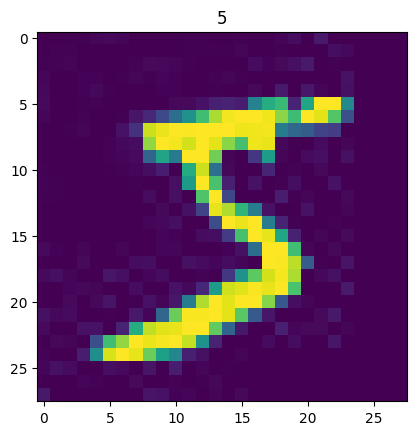

In [10]:
# 一、定义数据集
## 1.1 直接加载内置数据集

## 1.2 使用 paddle.io.Dataset 自定义数据集

'''
在实际的场景中，一般需要使用自有的数据来定义数据集，这时可以通过 paddle.io.Dataset 基类来实现自定义数据集。

可构建一个子类继承自 paddle.io.Dataset ，并且实现下面的三个函数：

__init__：完成数据集初始化操作，将磁盘中的样本文件路径和对应标签映射到一个列表中。

__getitem__：定义指定索引（index）时如何获取样本数据，最终返回对应 index 的单条数据（样本数据、对应的标签）。

__len__：返回数据集的样本总数。

注：
__getitem__ 函数的意义： 它类似 c++ 中的 [] 运算符重载，因此可以使得 Dataset 表现得像一个可以根据下标索引的序列容器，或者根据 key 索引的 map 容器。
__len__： 当对一个Dataset 类实例进行 len() 操作时，便会去调用 __len__ 函数
'''



# 下载原始的 MNIST 数据集并解压
# ! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
# ! tar -xf mnist.tar

import os
import cv2
import numpy as np
from paddle.io import Dataset
from paddle.vision.transforms import Normalize

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data_list = []
        with open(label_path,encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # print("call __getitem__")
        # 根据索引，从列表中取出一个图像
        image_path, label = self.data_list[index]
        # 读取灰度图
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype('float32')
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = int(label)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        # print("call __len__")
        return len(self.data_list)

# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 打印数据集样本数        
train_custom_dataset = MyDataset('mnist/train','mnist/train/label.txt', transform)
test_custom_dataset = MyDataset('mnist/val','mnist/val/label.txt', transform)
print('train_custom_dataset images: ',len(train_custom_dataset), 'test_custom_dataset images: ',len(test_custom_dataset)) # len() 函数会去调用 __len__ 函数


from matplotlib import pyplot as plt
image, label = train_custom_dataset[0] # [0] 会去调用 __getitem__ 函数
print('shape of image: ',image.shape)
plt.title(str(label))
plt.imshow(image[0])    


In [14]:
# 二、迭代读取数据集
## 2.1 使用 paddle.io.DataLoader 定义数据读取器

import paddle
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(train_custom_dataset, batch_size=64, shuffle=True, num_workers=3, drop_last=True)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(batch_id, images.shape, labels.shape))
    break

## 2.2 （可选）自定义采样器
from paddle.io import BatchSampler

# 定义一个批采样器，并设置采样的数据集源、采样批大小、是否乱序等
bs = BatchSampler(train_custom_dataset, batch_size=8, shuffle=True, drop_last=True)

print("BatchSampler 每轮迭代返回一个索引列表")
for batch_indices in bs:
    print(batch_indices)
    break

# 在 DataLoader 中使用 BatchSampler 获取采样数据 
'''
数据读取器 train_loader 通过 batch_sampler=bs 字段传入批采样器，即可根据这些索引获取对应的一组样本数据。
另外可以看到，batch_size、shuffle、drop_last这三个参数只在 BatchSampler 中设定。  
'''
train_loader = paddle.io.DataLoader(train_custom_dataset, batch_sampler=bs, num_workers=1)

print("在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据 ")
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(batch_id, images.shape, labels.shape))
    break


batch_id: 0, 训练数据shape: [64, 1, 28, 28], 标签数据shape: [64]
BatchSampler 每轮迭代返回一个索引列表
[51553, 50547, 29783, 55484, 6270, 3270, 22195, 33774]
在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据 
batch_id: 0, 训练数据shape: [8, 1, 28, 28], 标签数据shape: [8]


In [17]:
# 对比几个不同采样器的采样行为
from paddle.io import SequenceSampler, RandomSampler, BatchSampler, DistributedBatchSampler

class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([784]).astype('float32')
        label = np.random.randint(0, 9, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples
    
train_dataset = RandomDataset(100)

print('-----------------顺序采样----------------')
sampler = SequenceSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)
    
print('-----------------随机采样----------------')
sampler = RandomSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)

print('-----------------分布式采样----------------')
batch_sampler = DistributedBatchSampler(train_dataset, num_replicas=2, batch_size=10)

for index in batch_sampler:
    print(index)


-----------------顺序采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
-----------------随机采样----------------
[48, 25, 50, 10, 66, 31, 3, 79, 78, 13]
[18, 85, 27, 88, 81, 93, 11, 21, 68, 44]
[38, 96, 55, 5, 65, 57, 97, 32, 91, 46]
[49, 64, 6, 83, 86, 42, 24, 67, 47, 23]
[39, 17, 0, 84, 76, 71, 72, 43, 87, 34]
[98, 9, 40, 37, 14, 16, 12, 4, 7, 58]
[15, 95, 54, 99, 19, 29, 89, 36, 90, 77]
[70, 1, 35, 94, 45, 53, 74, 69, 26, 30]
[56, 41, 80, 75, 28, 33, 20, 60, 63, 59]
[73, 82, 61, 92, 22, 62, 51, 52, 2, 8]
-----------------分布式采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[40, 41, 42, 